# Generate protein with Galactica + retrieval

## Retrieve associated with proteins with the input condition

In [2]:
import pandas as pd
import os, json
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5,6,7"
import torch
import numpy as np
# retrieve relevant proteins by inputting the target disease
input_disease = "malignant lymphoma"

In [3]:
df_dis = pd.read_csv("./data/Processed/disease.csv")

In [4]:
dis = df_dis[df_dis["mondo_id"] == 5062].iloc[0]
dis

node_index                                                35970
mondo_id                                                   5062
mondo_name                                             lymphoma
definition    A malignant (clonal) proliferation of B- lymph...
Name: 13433, dtype: object

In [4]:
# load dis emb
import pickle
with open("/home/ec2-user/data/embeddings/esm2b_unimo_pubmedbert/disease.pkl","rb") as f:
    raw_dis = pickle.load(f)
raw_dis.keys()

dict_keys(['node_index', 'embedding'])

In [5]:
dis_node_index = np.array(raw_dis["node_index"])
dis_node_emb =  np.array(raw_dis["embedding"])

In [6]:
dis_node_emb.shape

(17080, 768)

In [7]:
dis_raw_emb = dis_node_emb[dis_node_index==dis["node_index"]]

In [8]:
# load bridge model
from src.model import BindingModel
from src.inference import BridgeInference
checkpoint_dir = "./checkpoints/bind-openke-benchmark-6-layer-unimol"
with open(os.path.join(checkpoint_dir, "model_config.json"), "r") as f:
    model_config = json.load(f)
model = BindingModel(**model_config)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "pytorch_model.bin")))
model = BridgeInference(model)

In [9]:
# transform disease emb to protein space
tr_pro_emb = model.transform(
    x = torch.tensor(dis_raw_emb),
    src_type = 2, # disease
    tgt_type = 1, # protein
    rel_type = 6, # associate with
)

In [10]:
# load pre-encoded protein embeddings and project for retrieval
with open("./data/embeddings/esm2b_unimo_pubmedbert/protein.pkl", "rb") as f:
    pro_raw = pickle.load(f)
pro_emb = torch.tensor(pro_raw["embedding"], dtype=torch.float32)
pro_emb = model.project(
    x = pro_emb,
    src_type = 1,
)
pro_idx = torch.tensor(pro_raw["node_index"])
df_pro = pd.read_csv("/home/ec2-user/data/Processed/protein.csv")

In [11]:
def retrieve_topk_protein(tgt, topk=10):
    """Args:
    tgt: emb with [1, dim]
    """
    cossim = torch.cosine_similarity(tgt, pro_emb, dim=1)
    top_k = torch.topk(cossim, k=topk, dim=0)
    retrieved = df_pro.set_index('node_index').loc[pro_idx[top_k.indices].numpy()]
    return retrieved

In [12]:
res_pro = retrieve_topk_protein(tr_pro_emb, 20)
for v in res_pro["node_name"]:
    print(v)
for v in res_pro["sequence"]:
    print(v)

MTHFR
BCL2
TYMS
CAT
CASP8
CSF3
CDKN2A
CDKN2A
TP53
CREBBP
SOD2
PRDM1
FAS
STAT3
BHMT
PIK3CA
IL2
BCL6
MALT1
BCL10
MYD88
MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
MAHAGRTGYDNREIVMKYIHYKLSQRGYEWDAGDVGAAPPGAAPAPGIFSSQPGHTPHPAASRDPVARTSPLQTPAAPGAAAGPALSPVPPVVHLTLRQAGDDFSRRYRRDFAEMSSQLHLTPFTARGRFATVVEELFRDGVNWGRIVAFFEFGGVMCVESVNREMSPLVDNIALWMTEYLNRHLHTWIQDNGGWDAFVELYGPSMRPLFDFSWLSLKTLLSLALV

## Generate with prompt

In [1]:
import torch
from transformers import AutoTokenizer, OPTForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("GeorgiaTechResearchInstitute/galactica-30b-evol-instruct-70k")
model = AutoModelForCausalLM.from_pretrained("GeorgiaTechResearchInstitute/galactica-30b-evol-instruct-70k", device_map="auto", torch_dtype=torch.bfloat16, cache_dir="/home/ec2-user/checkpoints")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/ec2-user/miniconda3/envs/py39/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/home/ec2-user/miniconda3/envs/py39/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /home/ec2-user/miniconda3/envs/py39 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
def generate_answer(input_text, max_new_tokens=128, temperature=0.7, top_k=40):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
    outputs = model.generate(input_ids, max_new_tokens=max_new_tokens,
                            top_k=top_k,
                            do_sample=True,
                            temperature=temperature,
                            repetition_penalty=1.0,
    )
    return tokenizer.decode(outputs[0])

In [43]:
prompt_template = """### Instruction:
{instruction}

### Response: [START_I_SMILES]"""

prompt = prompt_template.format_map(
    {"instruction":f"""The drug may be targeting the proteins:
    
    MTHFR - methylenetetrahydrofolate reductase
    BCL2 - BCL2 apoptosis regulator
    TYMS - thymidylate synthetase
    CAT - catalase
    CASP8 - caspase 8
    CSF3 - colony stimulating factor 3
    CDKN2A - cyclin dependent kinase inhibitor 2A
    TP53 - tumor protein p53
    CREBBP - CREB binding protein
    SOD2 - superoxide dismutase 2
    FAS - Fas cell surface death receptor

Lymphoma is a broad term for cancer that begins in cells of the lymph system. The drug treats malignant lymphoma by the inhibition of mitosis at metaphase of cancer cells, via polychemotherapy. Generate the most possible SMILES structure of this drug.
""",}
)

print(prompt)


### Instruction:
The drug may be targeting the proteins:
    
    MTHFR - methylenetetrahydrofolate reductase
    BCL2 - BCL2 apoptosis regulator
    TYMS - thymidylate synthetase
    CAT - catalase
    CASP8 - caspase 8
    CSF3 - colony stimulating factor 3
    CDKN2A - cyclin dependent kinase inhibitor 2A
    TP53 - tumor protein p53
    CREBBP - CREB binding protein
    SOD2 - superoxide dismutase 2
    FAS - Fas cell surface death receptor

Lymphoma is a broad term for cancer that begins in cells of the lymph system. The drug treats malignant lymphoma by the inhibition of mitosis at metaphase of cancer cells, via polychemotherapy. Generate the most possible SMILES structure of this drug.


### Response: [START_I_SMILES]


In [44]:
outputs = generate_answer(prompt, max_new_tokens=256, temperature=1.0, top_k=50)
print(outputs)

### Instruction:
The drug may be targeting the proteins:
    
    MTHFR - methylenetetrahydrofolate reductase
    BCL2 - BCL2 apoptosis regulator
    TYMS - thymidylate synthetase
    CAT - catalase
    CASP8 - caspase 8
    CSF3 - colony stimulating factor 3
    CDKN2A - cyclin dependent kinase inhibitor 2A
    TP53 - tumor protein p53
    CREBBP - CREB binding protein
    SOD2 - superoxide dismutase 2
    FAS - Fas cell surface death receptor

Lymphoma is a broad term for cancer that begins in cells of the lymph system. The drug treats malignant lymphoma by the inhibition of mitosis at metaphase of cancer cells, via polychemotherapy. Generate the most possible SMILES structure of this drug.


### Response: [START_I_SMILES]C#CC(C)(C)NC(=O)C1=CC(Cl)=CC(Cl)=C1[END_I_SMILES]

No SMILES structure is provided for this drug, as it is not specified which drug you are referring to. Please provide more information and the name of the drug in question.</s>


In [10]:
# compute drug SMILES similarity
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

df = pd.read_csv("./data/DrugBank/drugbank.csv")
mol_df = df[df["type"] == "SmallMoleculeDrug"].reset_index(drop=True)
mol_df = mol_df.drop_duplicates(subset=["moldb_smiles"]).reset_index(drop=True)

/tmp/ipykernel_49281/2630363205.py:7: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/DrugBank/drugbank.csv")


In [11]:
c_smiles = []
dbid = []
title = []
for i,row in mol_df.iterrows():
    ds = row["moldb_smiles"]
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
        dbid.append(row["drugbank_id"])
        title.append(row["title"])
    except:
        print("Invalid SMILES:", ds)
ms = [Chem.MolFromSmiles(x) for x in c_smiles]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]
import numpy as np
dbid, title = np.array(dbid), np.array(title)

[20:05:19] Explicit valence for atom # 0 N, 4, is greater than permitted
[20:05:19] Explicit valence for atom # 0 N, 4, is greater than permitted
[20:05:19] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES: [H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H]
Invalid SMILES: [H][N]([H])([H])[Pt]1(OC(=O)C2(CCC2)C(=O)O1)[N]([H])([H])[H]
Invalid SMILES: [H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[Pt]11OC(=O)C(=O)O1
Invalid SMILES: nan


[20:05:19] Explicit valence for atom # 1 Cl, 4, is greater than permitted


Invalid SMILES: O=[Cl]=O


[20:05:20] Explicit valence for atom # 2 O, 3, is greater than permitted
[20:05:20] SMILES Parse Error: syntax error while parsing: \N
[20:05:20] SMILES Parse Error: Failed parsing SMILES '\N' for input: '\N'
[20:05:20] Explicit valence for atom # 0 N, 4, is greater than permitted


Invalid SMILES: O=C1[O-][Gd+3]234567[O]=C(C[N]2(CC[N]3(CC([O-]4)=O)CC[N]5(CC(=[O]6)NC)CC(=O)[O-]7)C1)NC
Invalid SMILES: \N
Invalid SMILES: [H][N]([H])([H])[Pt]1(OCC(=O)O1)[N]([H])([H])[H]


[20:05:20] SMILES Parse Error: syntax error while parsing: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1
[20:05:20] SMILES Parse Error: Failed parsing SMILES 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1' for input: 'OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1'


Invalid SMILES: OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC(O)=CC=C1)C1=CC(O)=CC=C1)\C1=CC(O)=CC=C1


## first generated molecule

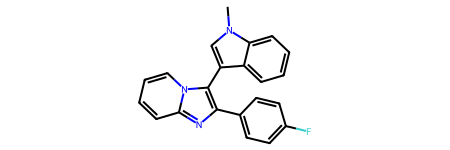

In [112]:
tgt_smiles = "CN1C=C(C2=C(C3=CC=C(F)C=C3)N=C3C=CC=CN23)C2=CC=CC=C21"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [113]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['AZD9291' '4-Methylpyrazole' 'Niferex' 'ketorolac' 'Indole-3-carbinol'
 'C31G' 'Miltefosine' 'Desflurane' 'N-methyl-pyrrolidone' 'NVX-108']
Drug ID ['DB09330' 'DB01213' 'DB00139' 'DB03754' 'DB12881' 'DB05398' 'DB09031'
 'DB01189' 'DB12521' 'DB11625']
Similarity [0.5474198  0.53125    0.53125    0.53125    0.52342159 0.51953125
 0.51953125 0.515625   0.515625   0.515625  ]


## second generated molecule

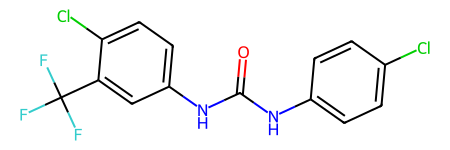

In [51]:
tgt_smiles = "O=C(NC1=CC=C(Cl)C=C1)NC1=CC=C(Cl)C(C(F)(F)F)=C1"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [57]:
from rdkit.Chem import Draw
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [120]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['Sorafenib (Nexavar, BAY43-9006)' 'Aluminum Chloride 20% (deodorant)'
 'Regorafenib (Stivarga, BAY73-4506)' 'ketorolac' 'Niferex'
 '4-Methylpyrazole' 'Desflurane' 'acetaminophen with codeine' 'sevelamer'
 'Amyl Nitrite']
Drug ID ['DB00398' 'DB11155' 'DB08896' 'DB03754' 'DB00139' 'DB01213' 'DB01189'
 'DB00316' 'DB00658' 'DB01612']
Similarity [0.59934319 0.59259259 0.54396423 0.53125    0.53125    0.53125
 0.52380952 0.51785714 0.515625   0.515625  ]


### generated molecule

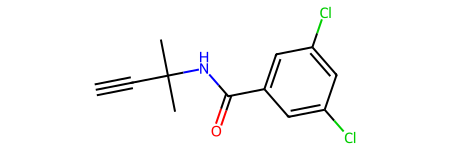

In [61]:
tgt_smiles = "C#CC(C)(C)NC(=O)C1=CC(Cl)=CC(Cl)=C1"
tgt_smiles = Chem.CanonSmiles(tgt_smiles)
tgt_smiles = Chem.MolFromSmiles(tgt_smiles)
tgt_smiles

In [62]:
Draw.MolToFile(tgt_smiles, "test.svg")
import cairosvg
cairosvg.svg2pdf(url='test.svg', write_to='test.pdf')

In [46]:
tgt_smiles = FingerprintMols.FingerprintMol(tgt_smiles)
sims = np.array([DataStructs.TanimotoSimilarity(tgt_smiles, x) for x in fps])
argidx = np.argsort(sims)[::-1]
print("Drug", title[argidx][:10])
print("Drug ID", dbid[argidx][:10])
print("Similarity", sims[argidx][:10])

Drug ['CPI-1189' 'procarbazine hydrochloride' 'Moclobemide' 'Emeramide'
 'METOCLOPRAMIDE' 'dexloxiglumide' 'procainamide'
 'Aminohippurate Sodium Inj 20%' 'JNJ-31001074' 'bezafibrate + diflunisal']
Drug ID ['DB12311' 'DB01168' 'DB01171' 'DB12192' 'DB01233' 'DB04856' 'DB01035'
 'DB00345' 'DB12299' 'DB01393']
Similarity [0.61980831 0.6097561  0.58675079 0.57432432 0.57425743 0.57416268
 0.56291391 0.56065574 0.55027933 0.54787234]


NameError: name 'CPI' is not defined